In [1]:
import deepmimo as dm
import numpy as np

import matplotlib.pyplot as plt

In [2]:
SUBCARRIER_SPACING = 30_000  # Hz - Standard 5G NR subcarrier spacing
SCALING_FACTOR = 1e6  # Channel scaling factor

N_BEAMS = 16
FOV = 180

In [3]:
def setup_channel_parameters():
    """
    Configure DeepMIMO channel parameters (same as load_sample_deepmimo_scenario.py).
    
    Returns:
        dm.ChannelParameters: Configured channel parameters object
    """
    ch_params = dm.ChannelParameters()
    
    # OFDM Configuration
    ch_params.ofdm.subcarriers = 32  # Number of OFDM subcarriers
    ch_params.ofdm.bandwidth = SUBCARRIER_SPACING * ch_params.ofdm.subcarriers
    ch_params.ofdm.selected_subcarriers = np.arange(0, ch_params.ofdm.subcarriers)
    
    # Base Station (BS) Antenna Configuration
    ch_params.bs_antenna.shape = np.array([32, 1])  # 32-element linear array
    ch_params.bs_antenna.rotation = np.array([0, 0, -135])  # Antenna rotation (degrees)
    
    # Multipath Configuration
    ch_params.num_paths = 20  # Maximum number of multipath components
    
    return ch_params

def to_dbm(amplitude):
    return (20 * np.log10(amplitude) + 30)


def calculate_best_beams(dataset, beam_sizes, fov=360):
    start = -fov/2
    active_users = dataset['active_users_count']
    bs_antenna_shape = dataset['ch_params_info'].item()["bs_antenna_shape"]

    beam_labels = np.zeros((active_users, len(beam_sizes)))
    for beam_idx, beam_size in enumerate(beam_sizes)    :
        end = fov/2 - fov/beam_size
        beam_angles = np.around(np.linspace(start, end, beam_size), 2)
        F1 = np.array([dm.steering_vec(bs_antenna_shape, phi=azi).squeeze()
               for azi in beam_angles])
        mean_amplitude = np.abs(F1 @ dataset['channels']).mean(axis=-1).squeeze(1)
        mean_amplitude_dbm = np.around(to_dbm(mean_amplitude), 3)

        best_beams = np.argmax(mean_amplitude_dbm, axis=1)
        beam_labels[:, beam_idx] = best_beams
    
    return beam_labels

In [4]:
params = setup_channel_parameters()
scenario = dm.load("city_25_instanbul_3p5")

Loading TXRX PAIR: TXset 1 (tx_idx 0) & RXset 0 (rx_idxs 83055)


In [5]:
_ = scenario.compute_channels(params)

Generating channels: 100%|██████████| 83055/83055 [00:00<00:00, 112194.05it/s]


In [6]:
active_mask = scenario.los != -1
channels = scenario.channel[active_mask].squeeze(1) * SCALING_FACTOR
print(channels.shape)

(18928, 32, 32)


In [7]:
start = -FOV/2
end = FOV/2 - FOV/N_BEAMS
 
beam_angles = np.around(np.linspace(start, end, N_BEAMS), 2)
beam_angles

array([-90.  , -78.75, -67.5 , -56.25, -45.  , -33.75, -22.5 , -11.25,
         0.  ,  11.25,  22.5 ,  33.75,  45.  ,  56.25,  67.5 ,  78.75])

In [25]:
# Compute Beamformers: F1 is [n_beams, n_ant]
F1 = np.array([dm.steering_vec(scenario.ch_params.bs_antenna.shape, phi=azi).squeeze()
               for azi in beam_angles])
F1.shape

(16, 32)

In [26]:
recv_bf_pwr_dbm = np.zeros((scenario.n_ue, N_BEAMS)) * np.nan
mean_amplitude = np.abs(F1 @ channels).mean(axis=-1)

print(mean_amplitude.shape)
print(recv_bf_pwr_dbm.shape)

(18928, 16)
(83055, 16)


In [27]:
recv_bf_pwr_dbm[active_mask] = np.around(to_dbm(mean_amplitude), 3)

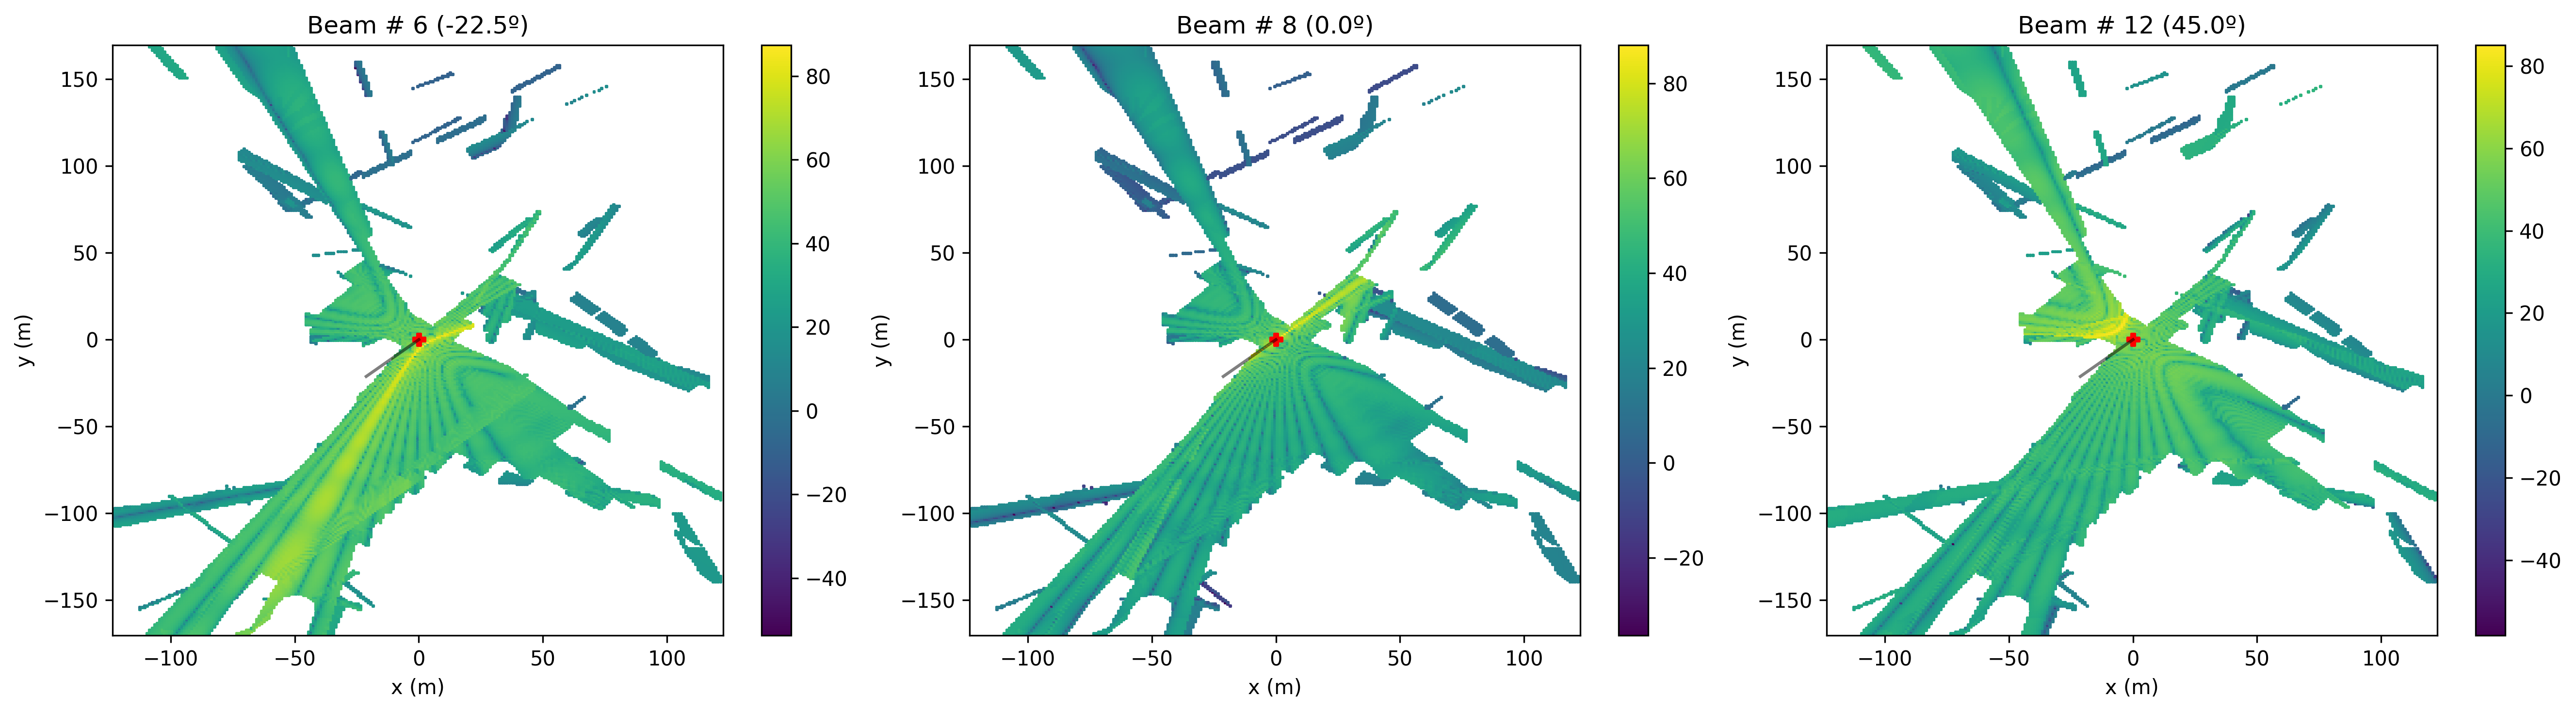

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=300, tight_layout=True)

for plt_idx, beam_idx in enumerate([6, 8, 12]):
    vmin = np.nanmin(recv_bf_pwr_dbm[:, beam_idx])
    vmax = np.nanmax(recv_bf_pwr_dbm[:, beam_idx])
    scenario.plot_coverage(recv_bf_pwr_dbm[:, beam_idx], ax=axes[plt_idx], lims=[vmin, vmax],
                          title=f'Beam # {beam_idx} ({beam_angles[beam_idx]:.1f}º)')

(<Axes: title={'center': 'Best Beams'}, xlabel='x (m)', ylabel='y (m)'>,
 <matplotlib.colorbar.Colorbar at 0x7cbae9354b10>)

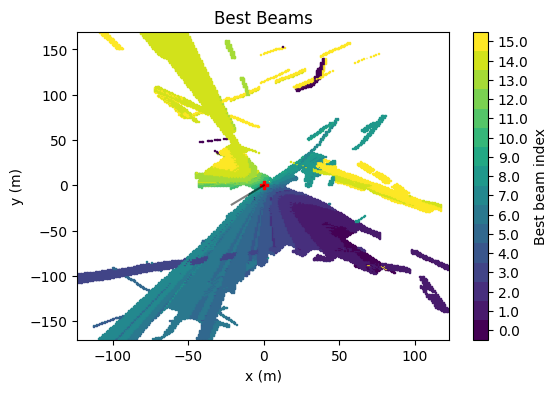

In [29]:
best_beams = np.argmax(recv_bf_pwr_dbm, axis=1).astype(float)
best_beams[np.isnan(recv_bf_pwr_dbm[:, 0])] = np.nan

dm.plot_coverage(scenario.rx_pos, best_beams, bs_pos=scenario.tx_pos.T, bs_ori=scenario.tx_ori,
                 title= 'Best Beams', cbar_title='Best beam index')

## Load pre-saved data

In [13]:
file_path = "processed_channels/pretrain/asu_campus_3p5_bs000.npz"
data = np.load(file_path, allow_pickle=True)
print(data.keys())
data['channels'].shape

KeysView(NpzFile 'processed_channels/pretrain/asu_campus_3p5_bs000.npz' with keys: channels, rx_pos, tx_pos, los, scenario_name...)


(85157, 1, 32, 32)

In [14]:
test_idx = -150
test_1 = data['channels'][test_idx].squeeze(0)
test_1.shape

(32, 32)

In [15]:
test_2 = np.array(channels[test_idx])
test_2.shape

(32, 32)

In [16]:
if np.sum(test_1 == test_2) == test_1.size:
    print("The two arrays are equal")
else:
    print("The two arrays are not equal")

The two arrays are equal


## Reproduce results using the saved data

In [24]:
beam_labels = calculate_best_beams(data, beam_sizes=[16, 32, 64])

In [25]:
beam_labels

array([[ 0., 17., 34.],
       [ 0., 17., 34.],
       [ 0., 17., 34.],
       ...,
       [11., 22., 45.],
       [11., 22., 45.],
       [11., 22., 45.]], shape=(85157, 3))

In [ ]:
best_beams = np.argmax(np.around(to_dbm(mean_amplitude), 3), axis=1)
best_beams.shape

(85157,)

In [37]:
beam_labels[:, 1]

array([17., 17., 17., ..., 22., 22., 22.], shape=(85157,))

In [38]:
best_beams

array([17, 17, 17, ..., 22, 22, 22], shape=(85157,))

In [39]:
np.sum(beam_labels[:, 1] == best_beams)

np.int64(85157)